# Finding the closest stable pose

This notebook provides an example of how to find the closest stable pose $T_\text{part}^\text{tag}(x, y, \gamma)$ to a given pose estimate $\widehat{T}_\text{part}^\text{tag}$ . It does this by formulating a nonlinear least-squares minimization problem that is solved by Levenberg-Marquardt using [SymForce](https://github.com/symforce-org/symforce). (This avoids the need to code a solver by ourselves, and in particular avoids the need to derive Jacobians by ourselves — both of these were done in the example code for extrinsic calibration that I shared with you earlier.)

To run this notebook, you need a conda environment with SymForce, for example one that is created as follows:

```
mamba create -n sf-test
mamba activate sf-test
mamba install python=3 numpy scipy sympy matplotlib notebook ipywidgets
pip install symforce
```

(I am using `mamba` instead of `conda`, and have installed everything with [`miniforge`](https://github.com/conda-forge/miniforge) instead of `miniconda`. If you like, you can use `conda`/`miniconda` instead.)

In hindsight, after looking at the results in this notebook, it is clear to me that — for the particular way in which we parameterize stable poses — "replacing the $z$ coordinate" is an equivalent way to generate the position of the closest stable pose (that is, the values of $x$ and $y$ produced by optimization are always the same as $x_\text{est}$ and $y_\text{est}$). It is likely that there is an analytical solution for $\gamma$ as well — again, for the particular way in which we parameterize stable poses. But, I would still use the method I propose here.

### Create nonlinear least squares problem to be solved by Levenberg-Marquardt

Initialize [symforce](https://github.com/symforce-org/symforce) with a nonzero epsilon to prevent singularities.

In [1]:
import symforce
symforce.set_epsilon_to_symbol()

Import everything else we need.

In [2]:
import symforce.symbolic as sf
import numpy as np
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce import codegen
import sym
import matplotlib.pyplot as plt

Create a symbolic function that maps $x, y, \gamma$ to a stable pose.

**THIS IS ONLY A SIMPLE EXAMPLE! YOU WOULD NEED TO MODIFY THIS FUNCTION SO IT ACTUALLY USES THE PARAMETERIZATION YOU DERIVED!**

In [3]:
def construct_stable_pose(x: sf.Scalar, y: sf.Scalar, gamma: sf.Scalar) -> sf.Pose3:
    return sf.Pose3(
        R=sf.Rot3.from_yaw_pitch_roll(gamma, 0, 0),
        t=sf.V3(x, y, 0),
    )

Create a numeric version of this function.

In [4]:
# construct_stable_pose_numeric = codegen.Codegen.function(
#     func=construct_stable_pose,
#     config=codegen.PythonConfig(),
# ).lambdify()

construct_stable_pose_numeric = construct_stable_pose

Create a function that computes the (weighted) error between a stable pose and a pose estimate.

In [5]:
def pose_residual(
    # Things we want to find
    x: sf.Scalar,
    y: sf.Scalar,
    gamma: sf.Scalar,
    # Things we are given
    T_est: sf.Pose3,
    w: sf.Scalar,
    # Things that are details of symforce
    epsilon: sf.Scalar,
) -> sf.V4:
    # Create stable pose
    T_sta = construct_stable_pose(x, y, gamma)
    # Find difference in position
    t_diff = T_est.t - T_sta.t
    # Find difference in angle
    a_diff = T_est.R.angle_between(T_sta.R)
    # Return error (could be weighted)
    return sf.V4(t_diff.x, t_diff.y, t_diff.z, w * a_diff)

Create factors (i.e., the list of all residuals).

In [6]:
factors = [
    Factor(
        residual=pose_residual,
        keys=[
            'x',
            'y',
            'gamma',
            'T_est',
            'w',
            'epsilon',
        ]
    )
]

Create optimizer.

In [7]:
optimizer = Optimizer(
    factors=factors,
    optimized_keys=[
        'x',
        'y',
        'gamma',
    ],
    debug_stats=True,
)

### Example in which the pose estimate is a stable pose

Choose a stable pose.

In [8]:
x_est = -0.1
y_est = 0.4
gamma_est = 0.2

Create initial values.

In [9]:
initial_values = Values(
    # Initial guess of stable pose
    x=0.,
    y=0.,
    gamma=0.,
    # Pose estimate
    T_est=construct_stable_pose_numeric(x_est, y_est, gamma_est),
    # Weight on angle error
    w=1.,
    # Epsilon
    epsilon=sym.epsilon,
)

Run the optimizer.

In [10]:
result = optimizer.optimize(initial_values)

[2023-11-14 20:35:35.031] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 0.105/0.000/0.026, rel reduction: 0.75000
[2023-11-14 20:35:35.031] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 0.026/0.000/0.001, rel reduction: 0.96000
[2023-11-14 20:35:35.031] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 0.001/0.000/0.000, rel reduction: 0.99654
[2023-11-14 20:35:35.032] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 0.000/0.000/0.000, rel reduction: 0.99976
[2023-11-14 20:35:35.032] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 0.000/0.000/0.000, rel reduction: 0.99998
[2023-11-14 20:35:35.032] [info] LM<sym::Optimize> [iter    5] lambda: 9.766e-04, error prev/linear/new: 0.000/0.000/0.000, rel reduction: 0.76594
[2023-11-14 20:35:35.032] [info] LM<sym::Optimize> [iter    6] lambda: 2.441e-04, error prev/linear/new: 0.000/0.000/0

Check for success.

In [11]:
print(result.status)

optimization_status_t.SUCCESS


Check final error.

In [12]:
print(result.error())

1.1102230246251565e-15


Get poses.

In [13]:
# Pose estimate (this was given and was not changed by the optimizer)
T_est = result.optimized_values['T_est']

# Stable pose that is closest to the pose estimate
T_sta = construct_stable_pose_numeric(
    result.optimized_values['x'],
    result.optimized_values['y'],
    result.optimized_values['gamma'],
)

Create helper functions to draw results.

In [14]:
def draw_frame(ax, R, t, s=1., linewidth=1., linestyle='-'):
    t = np.reshape(t, -1)
    R = np.reshape(R, (3,3))
    o = t + R @ np.array([0., 0., 0.])
    x = t + R @ np.array([s, 0., 0.])
    y = t + R @ np.array([0., s, 0.])
    z = t + R @ np.array([0., 0., s])
    ax.plot(o[0], o[1], o[2], 'k.')
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]], 'r', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]], 'g', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]], 'b', linewidth=linewidth, linestyle=linestyle)

def draw_view(ax, elev, azim, roll, T_sta, T_est, s=1.):
    ax.set_proj_type('ortho')
    
    # Pose estimate
    draw_frame(
        ax,
        T_est.R.to_rotation_matrix(),
        T_est.t,
        s=s,
    )
    
    # Stable pose that is closest to pose estimate
    draw_frame(
        ax,
        T_sta.R.to_rotation_matrix(),
        T_sta.t,
        s=s,
        linewidth=3.,
        linestyle='--',
    )
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([0, 1, 2])
    
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim, roll=roll)

def draw_results(T_sta, T_est, s=1.):
    fig, (ax, ax_x, ax_y, ax_z) = plt.subplots(1, 4, figsize=(20, 60), subplot_kw={'projection': '3d'})
    draw_view(ax, 15., 30., 0., T_sta, T_est, s=s)
    draw_view(ax_x, 0., -90., 0., T_sta, T_est, s=s)
    draw_view(ax_y, 0., 0., 0., T_sta, T_est, s=s)
    draw_view(ax_z, 90., -90., 0., T_sta, T_est, s=s)
    fig.tight_layout()
    plt.show()

Draw poses (should only see one, because both the pose estimate and the closest stable pose should be identical).

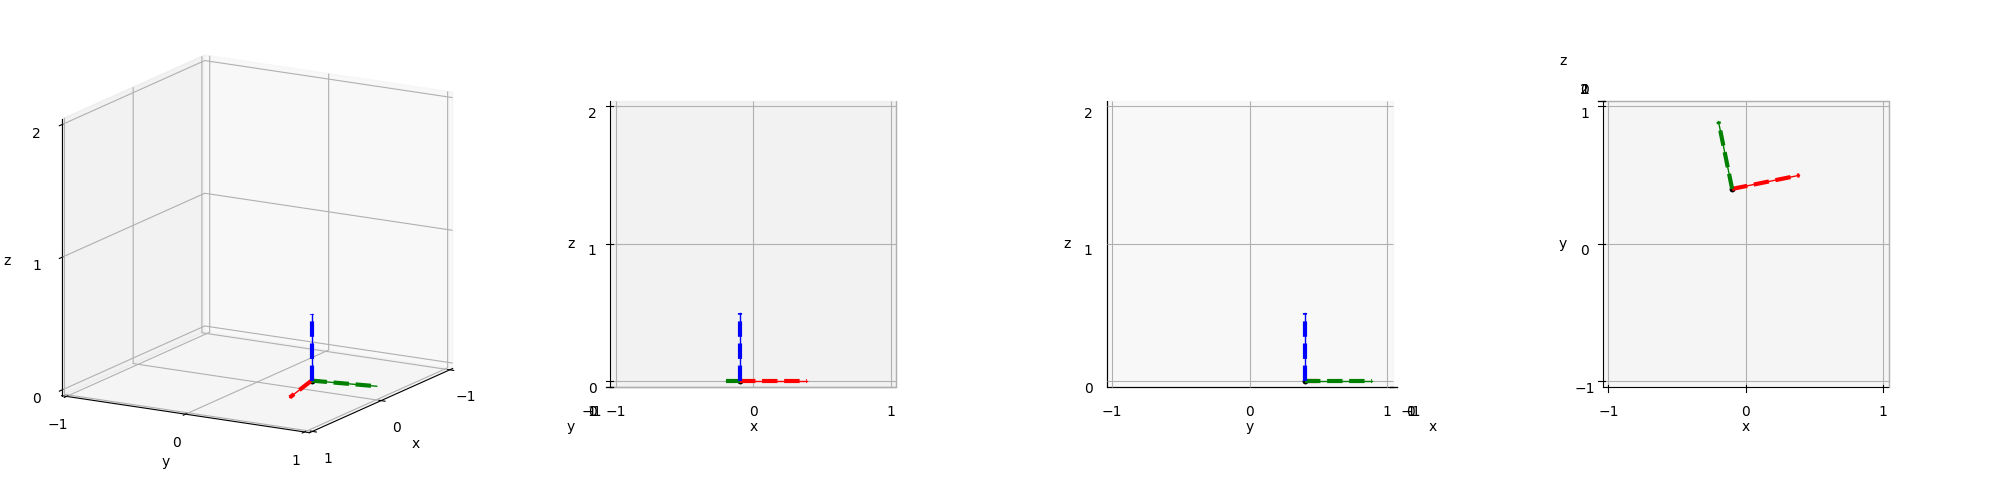

In [15]:
draw_results(T_sta, T_est, s=0.5)

Compare parameters of closest stable pose to parameters of pose estimate (should be the same).

In [16]:
x_sta = result.optimized_values['x']
y_sta = result.optimized_values['y']
gamma_sta = result.optimized_values['gamma']

print(f'{x_est:7.4f}, {y_est:7.4f}, {gamma_est:7.4f}   (pose estimate)')
print(f'{x_sta:7.4f}, {y_sta:7.4f}, {gamma_sta:7.4f}   (closest stable pose)')

-0.1000,  0.4000,  0.2000   (pose estimate)
-0.1000,  0.4000,  0.2000   (closest stable pose)


### Example in which the pose estimate is not a stable pose

Create initial values.

In [17]:
initial_values = Values(
    # Initial guess of stable pose
    x=0.,
    y=0.,
    gamma=0.,
    # Pose estimate
    T_est=sym.Pose3(
        R=sym.Rot3.from_yaw_pitch_roll(0.9, 0., 0.),
        t=np.array([0.2, -0.1, 0.4]),
    ),
    # Weight on angle error
    w=1.,
    # Epsilon
    epsilon=sym.epsilon,
)

Run the optimizer.

In [18]:
result = optimizer.optimize(initial_values)

[2023-11-14 20:35:35.989] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 0.510/0.000/0.188, rel reduction: 0.63235
[2023-11-14 20:35:35.989] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 0.188/0.000/0.084, rel reduction: 0.55040
[2023-11-14 20:35:35.989] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 0.084/0.000/0.080, rel reduction: 0.05083
[2023-11-14 20:35:35.989] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 0.080/0.000/0.080, rel reduction: 0.00019
[2023-11-14 20:35:35.989] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 0.080/0.000/0.080, rel reduction: 0.00000


Check for success.

In [19]:
print(result.status)

optimization_status_t.SUCCESS


Check final error.

In [20]:
print(result.error())

0.07999999821186066


Get poses.

In [21]:
# Pose estimate (this was given and was not changed by the optimizer)
T_est = result.optimized_values['T_est']

# Stable pose that is closest to the pose estimate
T_sta = construct_stable_pose_numeric(
    result.optimized_values['x'],
    result.optimized_values['y'],
    result.optimized_values['gamma'],
)

Draw poses (should have the same orientation, with one below the other).

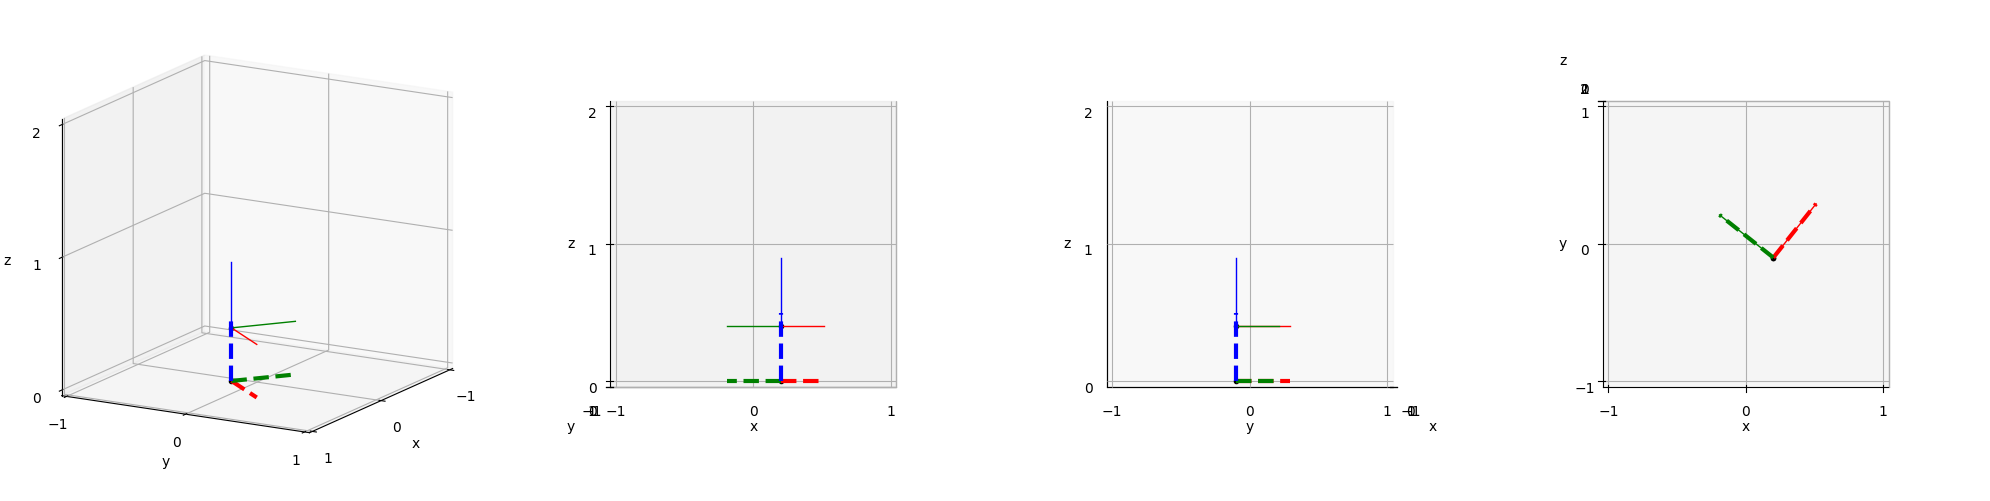

In [22]:
draw_results(T_sta, T_est, s=0.5)

### Another example in which the pose estimate is not a stable pose

Create initial values.

In [23]:
initial_values = Values(
    # Initial guess of stable pose
    x=0.,
    y=0.,
    gamma=0.,
    # Pose estimate
    T_est=sym.Pose3(
        R=sym.Rot3.from_yaw_pitch_roll(-0.2, 0.5, 0.8),
        t=np.array([-0.3, 0.2, 0.7]),
    ),
    # Weight on angle error
    w=1.,
    # Epsilon
    epsilon=sym.epsilon,
)

Run the optimizer.

In [24]:
result = optimizer.optimize(initial_values)

[2023-11-14 20:35:36.622] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 0.807/0.000/0.681, rel reduction: 0.15601
[2023-11-14 20:35:36.622] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 0.681/0.000/0.683, rel reduction: -0.00255
[2023-11-14 20:35:36.622] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e+00, error prev/linear/new: 0.681/0.000/0.666, rel reduction: 0.02220
[2023-11-14 20:35:36.622] [info] LM<sym::Optimize> [iter    3] lambda: 2.500e-01, error prev/linear/new: 0.666/0.000/0.662, rel reduction: 0.00569
[2023-11-14 20:35:36.622] [info] LM<sym::Optimize> [iter    4] lambda: 6.250e-02, error prev/linear/new: 0.662/0.000/0.686, rel reduction: -0.03621
[2023-11-14 20:35:36.623] [info] LM<sym::Optimize> [iter    5] lambda: 2.500e-01, error prev/linear/new: 0.662/0.000/0.663, rel reduction: -0.00099
[2023-11-14 20:35:36.623] [info] LM<sym::Optimize> [iter    6] lambda: 1.000e+00, error prev/linear/new: 0.662/0.00

Check for success.

In [25]:
print(result.status)

optimization_status_t.SUCCESS


Check final error.

In [26]:
print(result.error())

0.6617348790168762


Get poses.

In [27]:
# Pose estimate (this was given and was not changed by the optimizer)
T_est = result.optimized_values['T_est']

# Stable pose that is closest to the pose estimate
T_sta = construct_stable_pose_numeric(
    result.optimized_values['x'],
    result.optimized_values['y'],
    result.optimized_values['gamma'],
)

Draw poses (should have the same orientation, with one below the other).

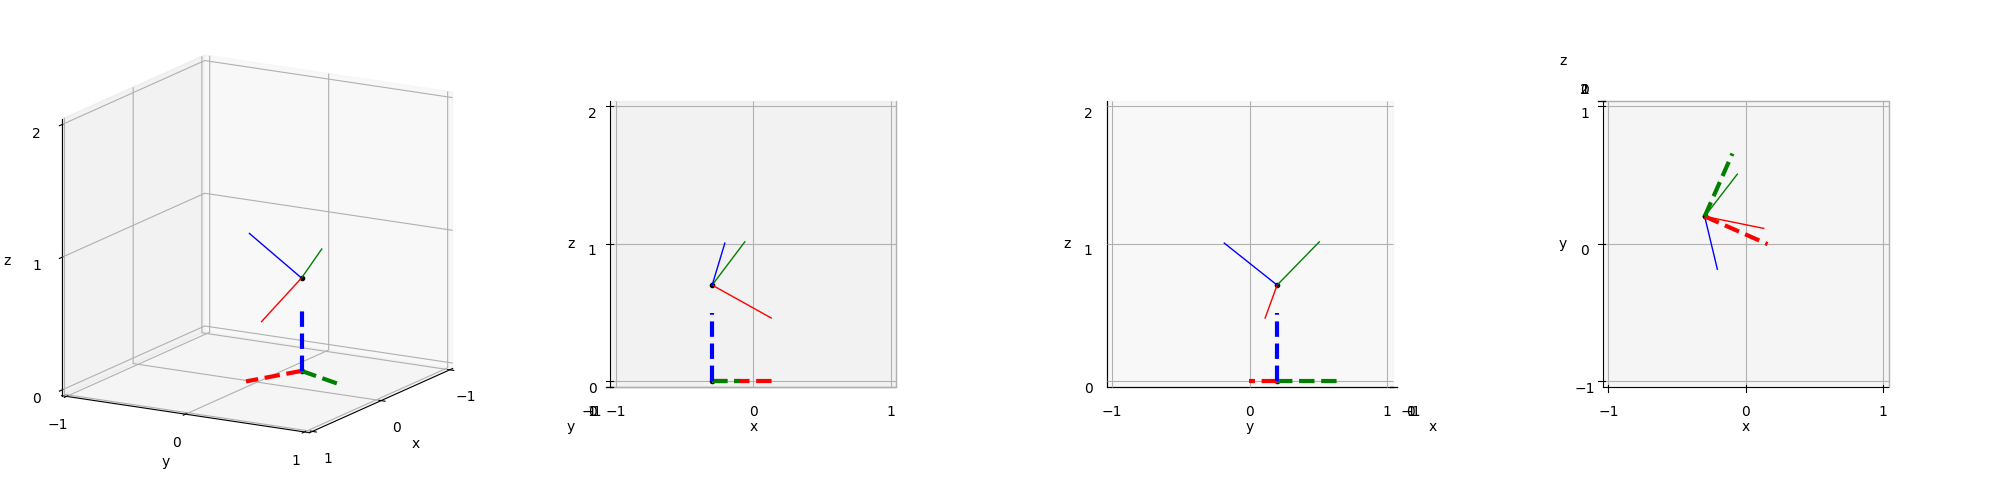

In [28]:
draw_results(T_sta, T_est, s=0.5)